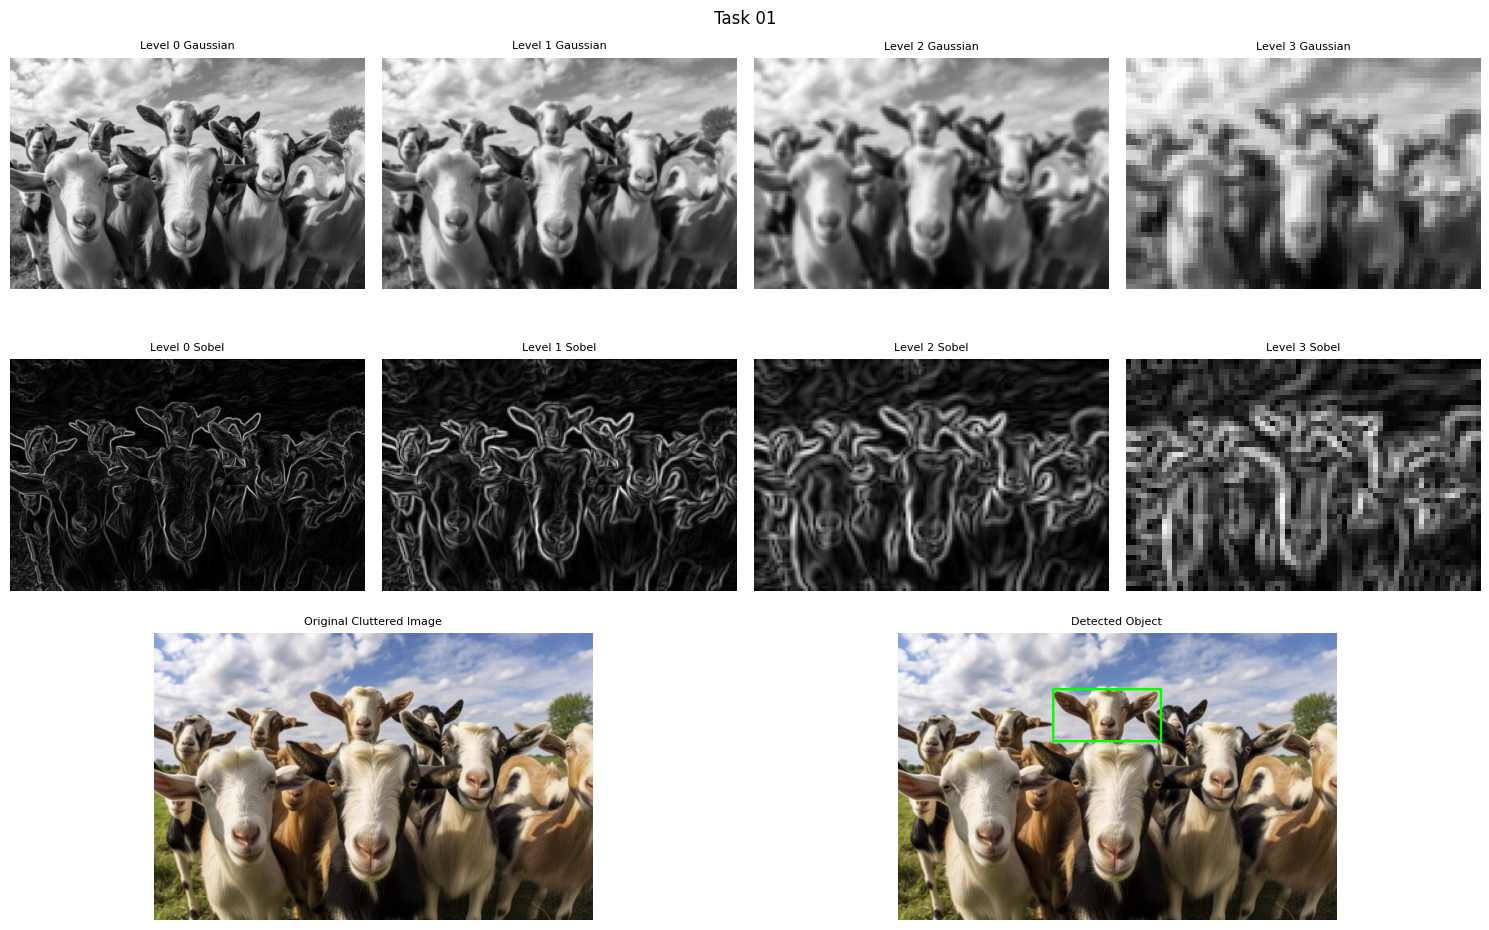

In [4]:
import cv2
import matplotlib.pyplot as plt

def create_gaussian_pyramid(image, levels):
    """
    Create a Gaussian pyramid of the specified number of levels.
    """
    pyramid = [image]
    for _ in range(levels - 1):
        pyramid.append(cv2.pyrDown(pyramid[-1]))
    return pyramid

def sobel_edges(image):
    """
    Apply Sobel edge detection to an image. As mentioned in the slide.
    """
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3) # Detect edges in x direction
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3) # Detect edges in y direction
    
    # Combining the gradients
    magnitude = cv2.magnitude(sobel_x, sobel_y)
    return cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

def template_match_pyramid_visualize(cluttered_path, template_path, pyramid_levels, match_threshold):
    """
    Perform template matching with visualization of Gaussian pyramid and Sobel levels, along with the final result.
    """
    # Load images
    cluttered_image = cv2.imread(cluttered_path)
    template = cv2.imread(template_path)
    
    final_detection = cluttered_image.copy()
    
    if cluttered_image is None or template is None:
        raise ValueError("Failed to load one or both images")
    
    # Convert to grayscale
    gray_cluttered = cv2.cvtColor(cluttered_image, cv2.COLOR_BGR2GRAY)
    gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    
    # Create pyramids
    pyramid_original = create_gaussian_pyramid(gray_cluttered, pyramid_levels)
    pyramid_edges = [sobel_edges(level) for level in pyramid_original]
    
    # Process template
    edge_template = sobel_edges(gray_template)
    
    # Store results for visualization
    matching_results = []
    
    # Process each pyramid level
    current_template = edge_template  # Start with the original edge template
    for i, edge_level in enumerate(pyramid_edges):
        if i > 0:
            # Downscale the template to match the current pyramid level
            current_template = cv2.pyrDown(current_template)
        
        # Template matching
        """Matching method: Correlation Coefficient Normalized(-1,1)"""
        result = cv2.matchTemplate(edge_level, current_template, cv2.TM_CCOEFF_NORMED)
        matching_results.append(result)
        
        # Find best match location
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        
        # Apply edited detection logic with max_val threshold check
        if max_val > match_threshold:
            # Draw detection on the original image at the finest level
            h, w = current_template.shape
            top_left = max_loc
            bottom_right = (top_left[0] + w, top_left[1] + h)
            cv2.rectangle(final_detection, top_left, bottom_right, (0, 255, 0), 2)
            break  # Exit loop once a match is found above the threshold

    # Create visualization
    fig = plt.figure(figsize=(15, 10))  # Adjusted figure size
    
    # Calculate grid parameters
    n_rows = 3  # Gaussian, Sobel, plus row for the final detection
    n_cols = pyramid_levels
    
    # Create gridspec for better control of subplot layout
    gs = fig.add_gridspec(n_rows, n_cols, hspace=0.05, wspace=0.05)
    
    # Plot pyramid levels (Gaussian and Sobel)
    for i in range(pyramid_levels):
        # Original image at each level (Gaussian)
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(pyramid_original[i], cmap='gray')
        ax.set_title(f'Level {i} Gaussian', fontsize=8)
        ax.axis('off')
        
        # Edge detection results (Sobel)
        ax = fig.add_subplot(gs[1, i])
        ax.imshow(pyramid_edges[i], cmap='gray')
        ax.set_title(f'Level {i} Sobel', fontsize=8)
        ax.axis('off')
    
    # Plot the original cluttered image in the first column of the last row
    ax = fig.add_subplot(gs[2, :2])
    ax.imshow(cv2.cvtColor(cluttered_image, cv2.COLOR_BGR2RGB))
    ax.set_title('Original Cluttered Image', fontsize=8)
    ax.axis('off')
    
    # Plot the final detected result in the second column of the last row
    ax = fig.add_subplot(gs[2, 2:])
    ax.imshow(cv2.cvtColor(final_detection, cv2.COLOR_BGR2RGB))
    ax.set_title('Detected Object', fontsize=8)
    ax.axis('off')
    
    # Add a main title
    plt.suptitle('Task 01', fontsize=12, y=0.92)
    
    # Adjust subplots to reduce extra padding around the figure
    plt.subplots_adjust(left=0.01, right=0.99, top=0.9, bottom=0.01)    
    
    return fig

if __name__ == "__main__":
    try:
        # Perform template matching with visualization
        fig = template_match_pyramid_visualize(
            'cluttered.jpg',
            'template.png',
            pyramid_levels=4,
            match_threshold=0.7
        )
        
        # Show the plot
        plt.show()
        
        # Save the visualization with higher DPI for better quality
        fig.savefig('pyramid_visualization.png', dpi=300, bbox_inches='tight')
        
    except Exception as e:
        print(f"Error: {str(e)}")


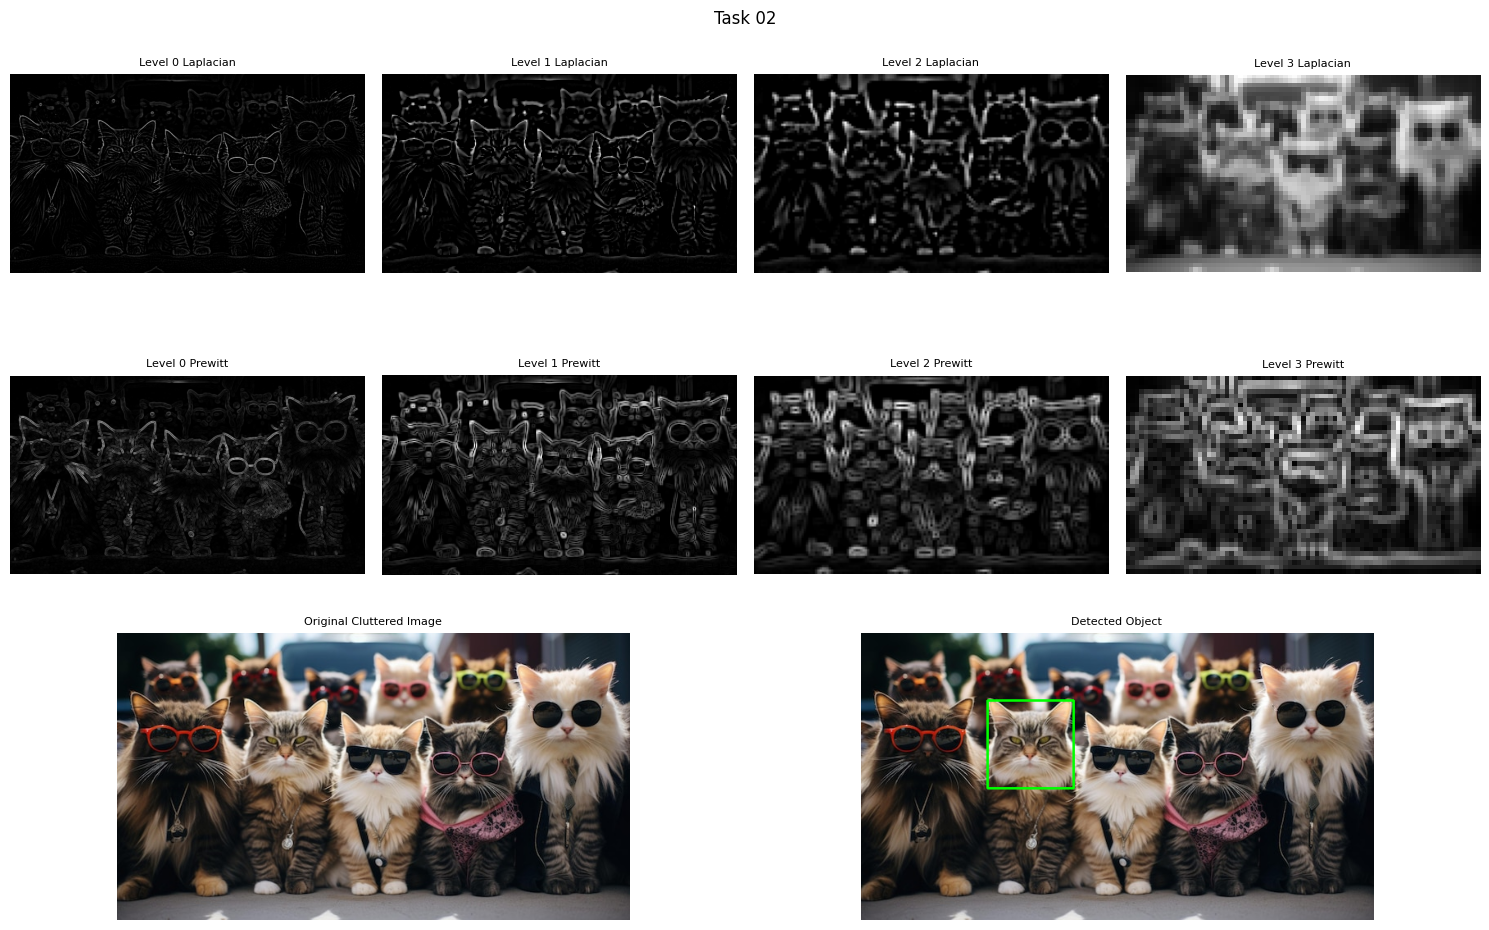

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def create_laplacian_pyramid(image, levels):
    """
    Create a Laplacian pyramid using Gaussian upsampling for the specified number of levels. As mentioned in the slide.
    """
    # Gaussian Pyramid
    gaussian_pyramid = [image]
    for i in range(levels - 1):
        down = cv2.pyrDown(gaussian_pyramid[-1])
        gaussian_pyramid.append(down)
    
    # Laplacian Pyramid
    laplacian_pyramid = []
    for i in range(levels - 1):
        # Upsample the next level in Gaussian Pyramid
        gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i + 1], dstsize=(gaussian_pyramid[i].shape[1], gaussian_pyramid[i].shape[0]))
        
        # Laplacian = current Gaussian level - upsampled Gaussian level
        laplacian = cv2.subtract(gaussian_pyramid[i], gaussian_expanded)
        laplacian_pyramid.append(laplacian)
    
    # Add the top level of the Gaussian pyramid to the Laplacian pyramid
    laplacian_pyramid.append(gaussian_pyramid[-1])
    return laplacian_pyramid

def prewitt_edge_detection(image):
    """
    Apply Prewitt edge detection to an image.
    """
    # Applying prewitt operator manually
    kernel_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], dtype = int)
    kernel_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], dtype = int)

    #aplying filter and convert to float32
    edge_x = cv2.filter2D(image, cv2.CV_32F, kernel_x)
    edge_y = cv2.filter2D(image, cv2.CV_32F, kernel_y)

    #combining the edge_x and edge_y to get the final edge
    magnitude = cv2.magnitude(edge_x, edge_y)

    return cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

def template_match_laplacian_visualize(cluttered_path, template_path, pyramid_levels, match_threshold):
    """
    Perform template matchimg with visualization of Laplacian pyramid and prewitt levels, along with the final result.
    """
    # Load images
    cluttered_image = cv2.imread(cluttered_path)
    template = cv2.imread(template_path)
    
    final_detection = cluttered_image.copy()
    
    if cluttered_image is None or template is None:
        raise ValueError("Failed to load one or both images")
    
    # Convert to grayscale
    gray_cluttered = cv2.cvtColor(cluttered_image, cv2.COLOR_BGR2GRAY)
    gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    
    # Create pyramids
    laplacian_pyramid = create_laplacian_pyramid(gray_cluttered, pyramid_levels)
    prewitt_edges = [prewitt_edge_detection(level) for level in laplacian_pyramid]
    
    # Process template
    edge_template = prewitt_edge_detection(gray_template)
    
    # Store results for visualization
    matching_results = []
    detected_locations = []
    
    # Process each pyramid level
    current_template = edge_template  # Start with the original edge template
    for i, edge_level in enumerate(prewitt_edges):
        if i > 0:
            # Downscale the template to match the current pyramid level
            current_template = cv2.pyrDown(current_template)
        
        # Template matching
        """Matching method: Correlation Coefficient Normalized(-1,1)"""
        result = cv2.matchTemplate(edge_level, current_template, cv2.TM_CCOEFF_NORMED)
        matching_results.append(result)
        
        # Find best match location
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        detected_locations.append((max_loc, max_val, current_template.shape))

        # Apply edited detection logic with max_val threshold check
        if max_val > match_threshold:
            # Draw detection on the original image at the finest level
            h, w = current_template.shape
            top_left = max_loc
            bottom_right = (top_left[0] + w, top_left[1] + h)
            cv2.rectangle(final_detection, top_left, bottom_right, (0, 255, 0), 2)
            break  # Exit loop once a match is found above the threshold

    # Create visualization
    fig = plt.figure(figsize=(15, 10))  # Adjusted figure size
    
    # Calculate grid parameters
    n_rows = 3  # Laplacian, Prewitt, plus row for the final detection
    n_cols = pyramid_levels
    
    # Create gridspec for better control of subplot layout
    gs = fig.add_gridspec(n_rows, n_cols, hspace=0.05, wspace=0.05)
    
    # Plot pyramid levels (Laplacian and Prewitt)
    for i in range(pyramid_levels):
        # Original image at each level (Laplacian)
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(laplacian_pyramid[i], cmap='gray')
        ax.set_title(f'Level {i} Laplacian', fontsize=8)
        ax.axis('off')
        
        # Edge detection results (Prewitt)
        ax = fig.add_subplot(gs[1, i])
        ax.imshow(prewitt_edges[i], cmap='gray')
        ax.set_title(f'Level {i} Prewitt', fontsize=8)
        ax.axis('off')
    
    # Plot the original cluttered image in the first column of the last row
    ax = fig.add_subplot(gs[2, :2])
    ax.imshow(cv2.cvtColor(cluttered_image, cv2.COLOR_BGR2RGB))
    ax.set_title('Original Cluttered Image', fontsize=8)
    ax.axis('off')
    
    # Plot the final detected result in the second column of the last row
    ax = fig.add_subplot(gs[2, 2:])
    ax.imshow(cv2.cvtColor(final_detection, cv2.COLOR_BGR2RGB))
    ax.set_title('Detected Object', fontsize=8)
    ax.axis('off')
    
    # Add a main title
    plt.suptitle('Task 02', fontsize=12, y=0.92)
    
    
    # Adjust subplots to reduce extra padding around the figure
    plt.subplots_adjust(left=0.01, right=0.99, top=0.9, bottom=0.01)
    
    return fig

if __name__ == "__main__":
    try:
        # Perform template matching with visualization
        fig = template_match_laplacian_visualize(
            'cluttered2.jpg',
            'template2.png',
            pyramid_levels=4,
            match_threshold=0.6
        )
        
        # Show the plot
        plt.show()  
        
        # Save the visualization with higher DPI for better quality
        fig.savefig('laplacian_pyramid_visualization.png', dpi=300, bbox_inches='tight')
        
    except Exception as e:
        print(f"Error: {str(e)}")


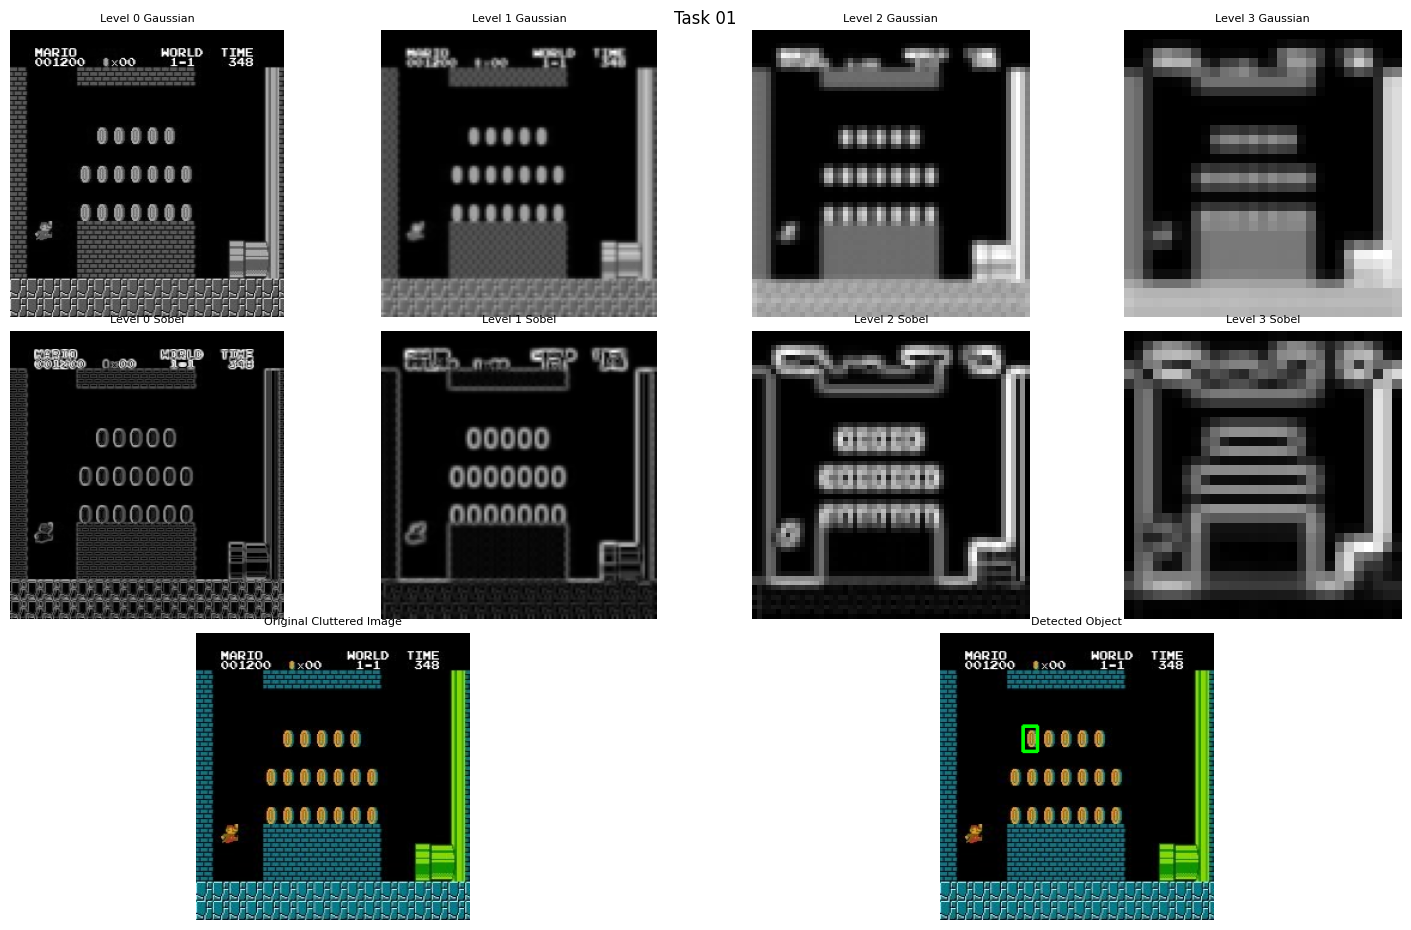

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def create_gaussian_pyramid(image, levels):
    """
    Create a Gaussian pyramid of the specified number of levels.
    """
    pyramid = [image]
    for _ in range(levels - 1):
        pyramid.append(cv2.pyrDown(pyramid[-1]))
    return pyramid

def detect_edges(image):
    """
    Apply Sobel edge detection to an image.
    """
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = cv2.magnitude(sobel_x, sobel_y)
    return cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

def template_match_pyramid_visualize(cluttered_path, template_path, pyramid_levels=3, match_threshold=0.7):
    """
    Perform template matching with visualization of Gaussian pyramid and Sobel levels, along with the final result.
    """
    # Load images
    cluttered_image = cv2.imread(cluttered_path)
    template = cv2.imread(template_path)
    
    if cluttered_image is None or template is None:
        raise ValueError("Failed to load one or both images")
    
    # Convert to grayscale
    gray_cluttered = cv2.cvtColor(cluttered_image, cv2.COLOR_BGR2GRAY)
    gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    
    # Create pyramids
    pyramid_original = create_gaussian_pyramid(gray_cluttered, pyramid_levels)
    pyramid_edges = [detect_edges(level) for level in pyramid_original]
    
    # Process template
    edge_template = detect_edges(gray_template)
    
    # Store results for visualization
    matching_results = []
    detected_locations = []
    
    # Process each pyramid level
    for i, edge_level in enumerate(pyramid_edges):
        # Resize template for current level
        scale_factor = 2 ** i
        if i > 0:
            current_template = cv2.resize(edge_template, 
                                       (edge_template.shape[1] // scale_factor,
                                        edge_template.shape[0] // scale_factor))
        else:
            current_template = edge_template
        
        # Template matching
        result = cv2.matchTemplate(edge_level, current_template, cv2.TM_CCOEFF_NORMED)
        matching_results.append(result)
        
        # Find best match location
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        detected_locations.append((max_loc, max_val, current_template.shape))

    # Draw detection on the original image at the finest level
    final_detection = cluttered_image.copy()
    if detected_locations[0][1] > match_threshold:
        loc = detected_locations[0][0]
        h, w = detected_locations[0][2]
        cv2.rectangle(final_detection, loc, (loc[0] + w, loc[1] + h), (0, 255, 0), 2)

    # Create visualization
    fig = plt.figure(figsize=(15, 10))  # Adjusted figure size
    
    # Calculate grid parameters
    n_rows = 3  # Gaussian, Sobel, plus row for the final detection
    n_cols = pyramid_levels
    
    # Create gridspec for better control of subplot layout
    gs = fig.add_gridspec(n_rows, n_cols, hspace=0.05, wspace=0.05)
    
    # Plot pyramid levels (Gaussian and Sobel)
    for i in range(pyramid_levels):
        # Original image at each level (Gaussian)
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(pyramid_original[i], cmap='gray')
        ax.set_title(f'Level {i} Gaussian', fontsize=8)
        ax.axis('off')
        
        # Edge detection results (Sobel)
        ax = fig.add_subplot(gs[1, i])
        ax.imshow(pyramid_edges[i], cmap='gray')
        ax.set_title(f'Level {i} Sobel', fontsize=8)
        ax.axis('off')
    
    # Plot the original cluttered image in the first column of the last row
    ax = fig.add_subplot(gs[2, :2])
    ax.imshow(cv2.cvtColor(cluttered_image, cv2.COLOR_BGR2RGB))
    ax.set_title('Original Cluttered Image', fontsize=8)
    ax.axis('off')
    
    # Plot the final detected result in the second column of the last row
    ax = fig.add_subplot(gs[2, 2:])
    ax.imshow(cv2.cvtColor(final_detection, cv2.COLOR_BGR2RGB))
    ax.set_title('Detected Object', fontsize=8)
    ax.axis('off')
    
    # Add a main title
    plt.suptitle('Task 01', fontsize=12, y=0.92)
    
# Adjust subplots to reduce extra padding around the figure
    plt.subplots_adjust(left=0.01, right=0.99, top=0.9, bottom=0.01)    
    
    return fig

# Example usage
if __name__ == "__main__":
    try:
        # Perform template matching with visualization
        fig = template_match_pyramid_visualize(
            '2.jpg',
            '3.png',
            pyramid_levels=4,
            match_threshold=0.7
        )
        
        # Show the plot
        plt.show()
        
        # Save the visualization with higher DPI for better quality
        fig.savefig('pyramid_visualization.png', dpi=300, bbox_inches='tight')
        
    except Exception as e:
        print(f"Error: {str(e)}")
